In [1146]:
from cv2 import imread
from matplotlib.pyplot import figure, title, subplot, axis, imshow, show, hist, tight_layout
from numpy import zeros, uint8, r_, unravel_index, argpartition, c_, hstack, mean, sqrt, nan, sum, abs, max, float32, \
    empty, \
    pi, copy, vstack, nan_to_num, multiply
from numpy.random import normal, rand
from scipy.fftpack import dct, idct


# 2. Hiding secret message in DCT

In [1147]:
figure_size = (18,7)

def load(keyword, code=None):
    # read image by file
    # if code is 0 it reads the image with grayscale
    i =  imread('images/'+keyword+'.jpg', code)
    if i is None:
        i = imread('images/'+keyword+'.jpeg', code)
    if i is None:
        i = imread('images/'+keyword+'.tif', code)
    if i is None:
        print("Not found any ",keyword," jpg or jpeg")
    return i
def show_images(name,images,desc,col=None):
    figure(figsize=figure_size)
    n = len(images)
    for k in range(0,n):
        img = images[k].astype(uint8)
        tit = name + " " + desc[k]
        if not col is None:
            c = col[k]
            subplot(1,n,k+1), title(tit), axis('off'), imshow(img,cmap=c)
        else :
            subplot(1,n,k+1), title(tit), axis('off'), imshow(img)
    tight_layout()
    show()

def dct2(a):
    # 2-D DCT tf
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

def idct2(a):
    # 2-D DCT inverse tf
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

def extract_dct(img):
    # extract 8x8 2-D DCT coefficients
    dct_blocks = zeros(img.shape)            # out shape
    for i in r_[:img.shape[0]:8]:            # block-wise dct
        for j in r_[:img.shape[1]:8]:
            dct_blocks[i:i + 8, j:j + 8] = dct2(img[i:i + 8,j:j + 8])

    return dct_blocks

def k_largest_values(a, _k):
    # stretch the array
    # sort by values and gather indexes
    # gather last K-1 indexes from sorted array
    # reshape indexes and gather values from them
    k_dcts = zeros(a.shape)

    for i in r_[:a.shape[0]:8]:
        for j in r_[:a.shape[1]:8]:
            block = copy(a[i:i+8 , j:j+8])                  # non -dc
            flat = abs(block).ravel()
            highest_k = unravel_index(argpartition(flat,-_k)[-_k:], block.shape)
            filtered = zeros(block.shape)
            filtered[highest_k] = block[highest_k]
            k_dcts[i:i+8 , j:j+8] = filtered
            k_dcts[i,j] = block[0,0]


    print("%d non-zero coefficients " %k_dcts[k_dcts != 0].__len__())

    return k_dcts

def find_best_k_dct(_dct, img, debug=False):
    size = img.shape
    K_dct = None           # out params
    K = -1

    for _k in range(24,0,-4):                         # testing range
        _restored = zeros(size)                        # out image
        k_dcts = k_largest_values(_dct, _k)             # indexes of highest K coefficients
        for i in r_[:size[0]:8]:                      # block-wise idct from filtered coefficients
            for j in r_[:size[1]:8]:
                _restored[i:(i+8),j:(j+8)] = idct2(k_dcts[i:(i+8),j:(j+8)] )

        if debug:                               # some debug
            figure(figsize=(20,10))
            subplot(1,3,1), axis('off'), imshow(hstack((img, _restored)) ,'gray',vmin=0,vmax=255), title("original - restored")
            subplot(1,3,2), axis('off'), imshow(abs(img - _restored), 'gray'), title("difference image")
            subplot(1,3,3), imshow(hstack((_dct, k_dcts)) ,'gray',vmin=0,vmax=max(k_dcts)*0.01), title("all dct - %d dct" %_k)
            show()

        if _k == 16 :                           # best one found by inspection
            K = _k                               # store out params
            K_dct = k_dcts

    return K, K_dct

def embed(_k_dct, s, a):
    # generate K random numbers from gaussian distribution with mean 0 and var s
    size = _k_dct.shape
    _wk = zeros(size)
    _marked = zeros(size)


    for i in r_[:size[0]:8]:
        for j in r_[:size[1]:8]:
            block = _k_dct[i:i+8, j:j+8]
            gaussian = normal(0,s,block.shape[0] * block.shape[1]).reshape(block.shape)
            _wk[i:i+8, j:j+8] = gaussian
            _marked[i:i+8, j:j+8] = nan_to_num(block * (1 - a * gaussian))
            _marked[i,j] = block[0,0]                       # put dc component back

    return _wk, _marked

def insert_watermark(img, _k_dct, s, a, debug=False):
    # embed watermark from K largest non-DC DCT coefficients
    _wk, _marked = embed(_k_dct, s, a)                      # from gaussian
    _restored = zeros(sz)                                  # out image

    for i in r_[:sz[0]:8]:              # block-wise idct
        for j in r_[:sz[1]:8]:
            _restored[i:(i+8),j:(j+8)] = idct2(_marked[i:(i+8),j:(j+8)])

    diff = abs(img-_restored)                 # gather difference

    if debug:                           # some debug + display asked
        print("\nTesting sigma=%f , alpha=%f \n" %(s,a))
        figure(figsize=figure_size)
        subplot(2,2,1), axis("off"), title("Original") , imshow(img, cmap='gray')                  # the original image
        subplot(2,2,2), axis("off"), title("Image with watermark") , imshow(_restored, cmap='gray') # the watermarked image
        subplot(2,2,3), axis("off"), title("Difference image") , imshow(diff, cmap='gray')         # the difference image
        subplot(2,2,4), title("histogram difference") , hist(diff)                                 # the histogram of the difference image
        show()

    return _wk, _marked, _restored

## 2.1 Watermark insertion
Chose a *_grayscale_* image to which will insert a watermark

##### Compute the 2-D DCT of the image in a block-wise manner.

In [1148]:
image = load("cameraman", 0)
sz = image.shape
all_dct = extract_dct(image)

##### Choose its $ K $ coefficients, $ c_1 , c_2 ,..., c_K $
with the largest magnitude, choose K such that creates an image that
still looks like the original one, just using fewer DCT coefficients

24576 non-zero coefficients 


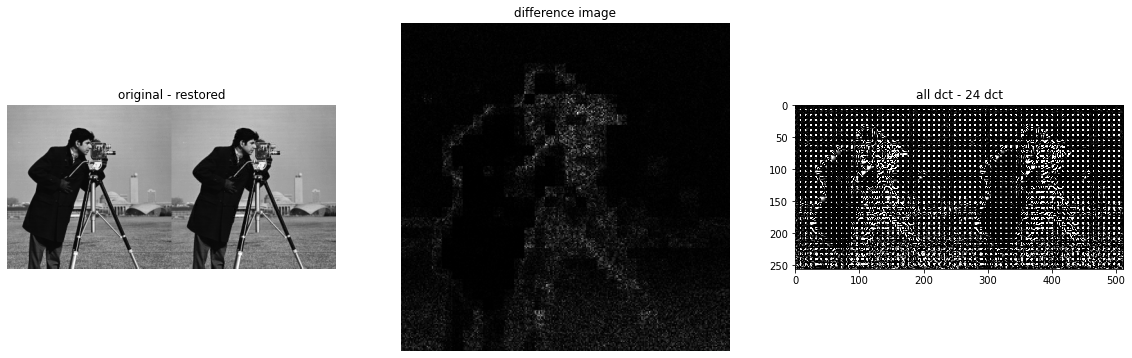

20480 non-zero coefficients 


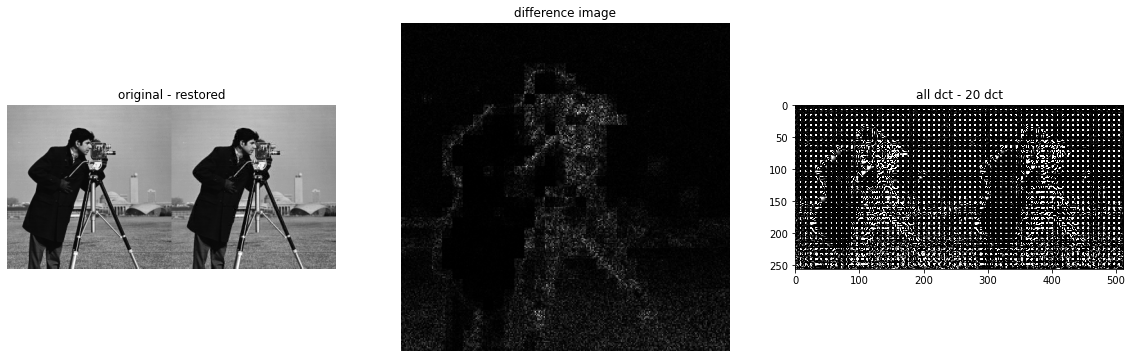

16384 non-zero coefficients 


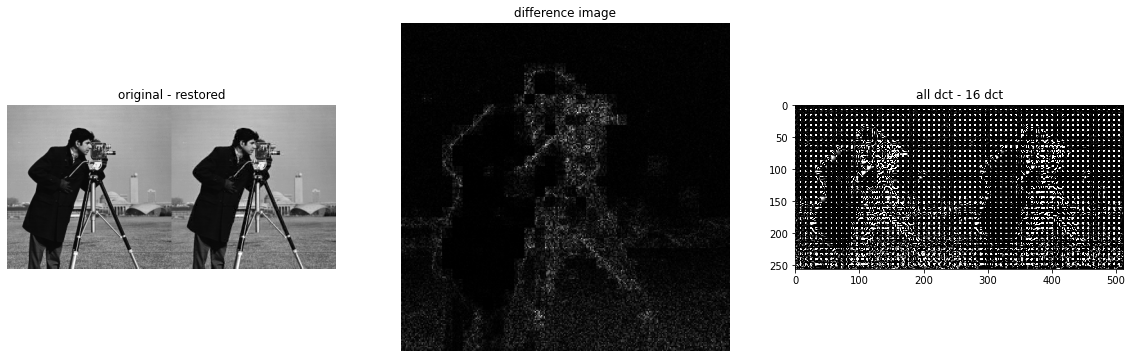

12288 non-zero coefficients 


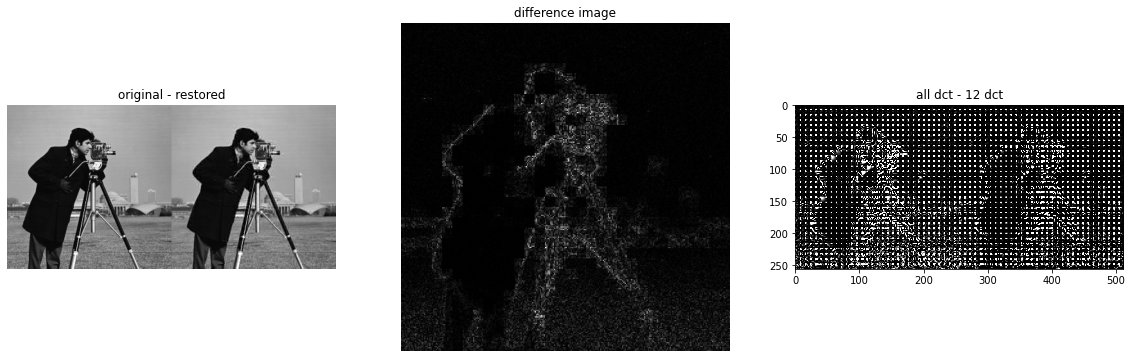

8192 non-zero coefficients 


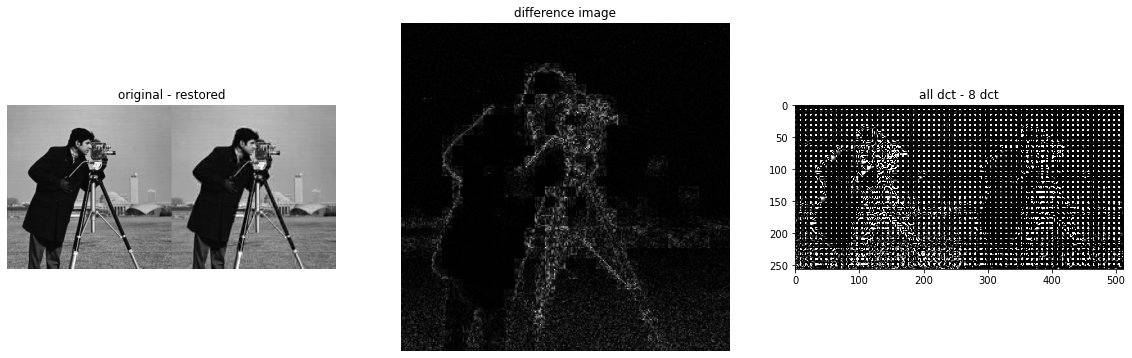

4096 non-zero coefficients 


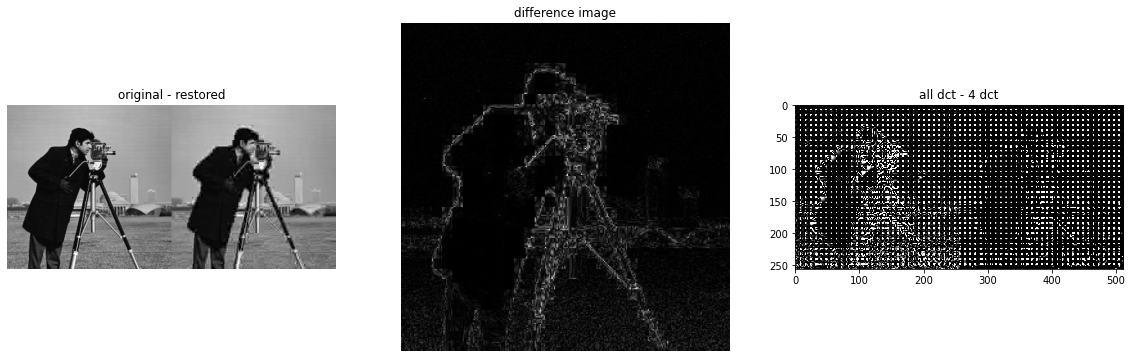

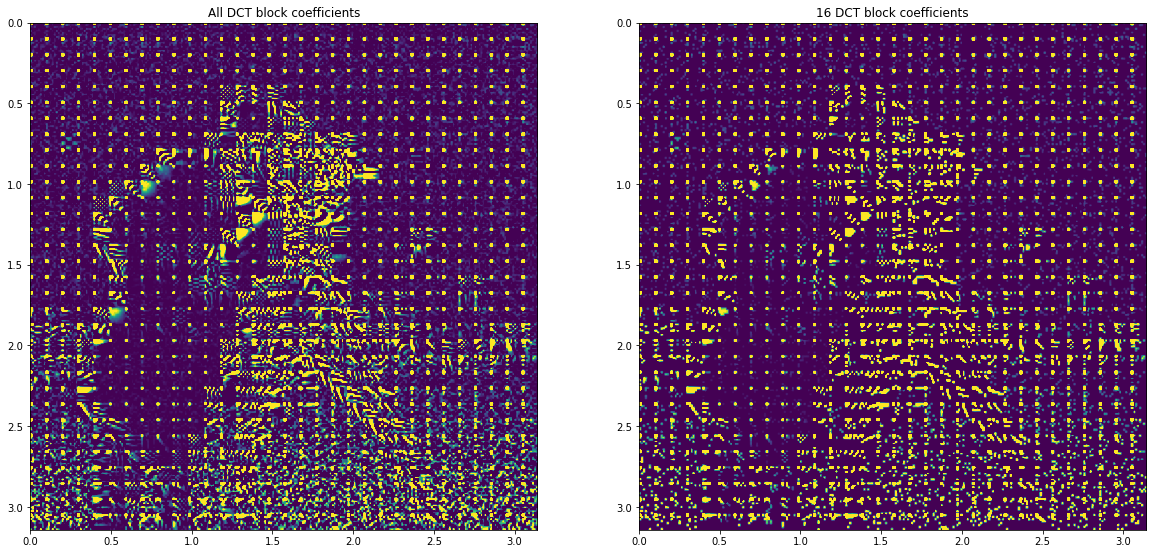

In [1149]:
# testing
k, k_dct = find_best_k_dct(all_dct, image, debug=True)

figure(figsize=(20,10))
subplot(1,2,1), imshow(all_dct, vmax= max(all_dct) * 0.01,vmin = 0, extent=[0,pi,pi,0]), title( "All DCT block coefficients")
subplot(1,2,2), imshow(k_dct, vmax=max(k_dct) * 0.01, vmin = 0, extent=[0, pi, pi, 0]), title("%d DCT block coefficients" % k)
show()

##### Create a watermark by generating K-element pseudo-random numbers,
$ w_1, w_2, ..., w_K $ that follow a Gaussian distribution with mean $ \mu = 0 $ and
variance $ \sigma ^2 $ to be chosen


Testing sigma=0.010000 , alpha=0.100000 



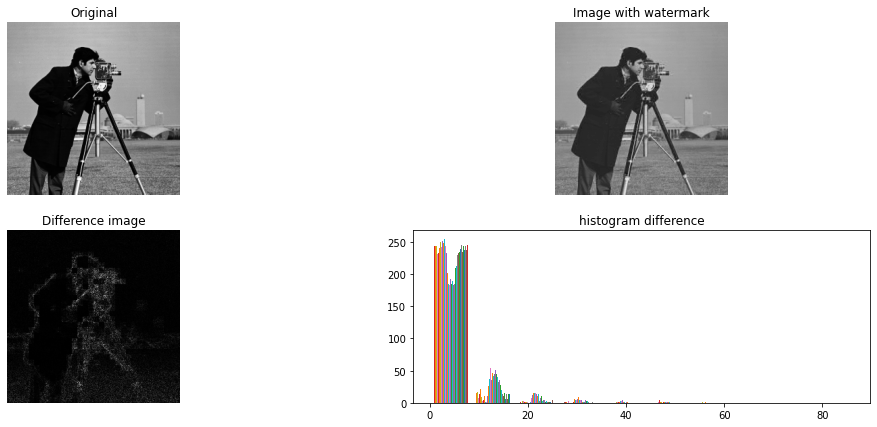


Testing sigma=0.100000 , alpha=0.100000 



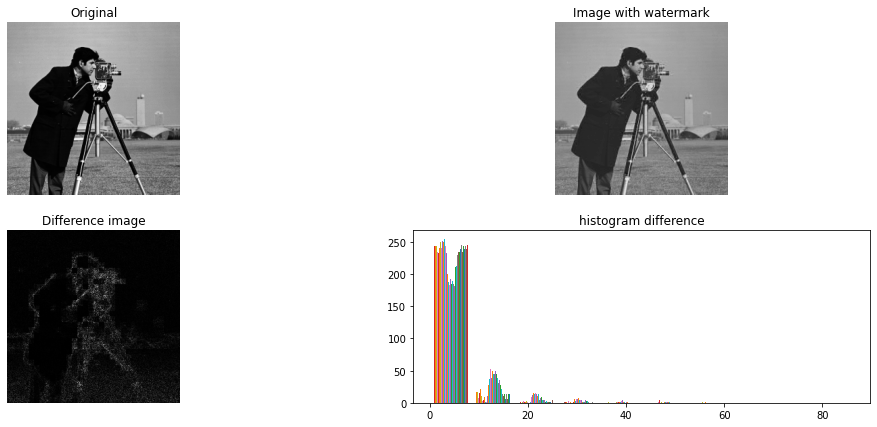


Testing sigma=0.500000 , alpha=0.100000 



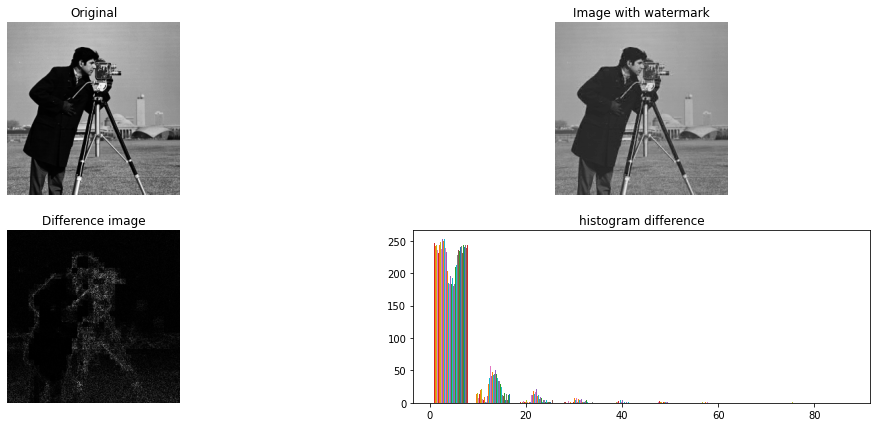


Testing sigma=0.010000 , alpha=0.250000 



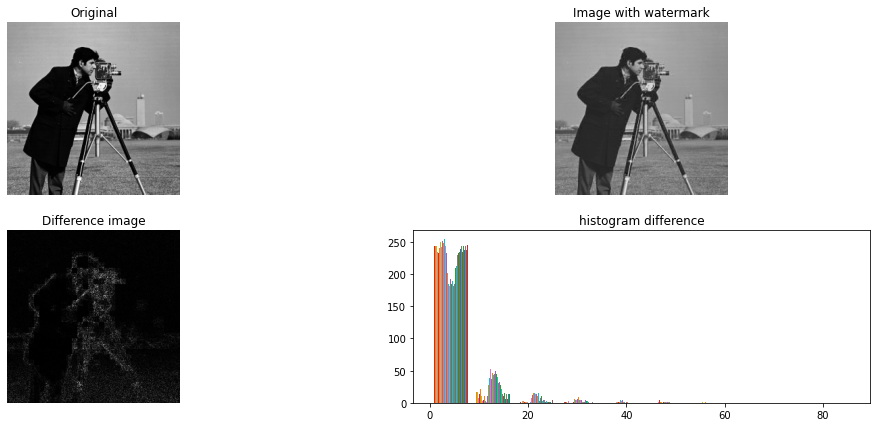


Testing sigma=0.100000 , alpha=0.250000 



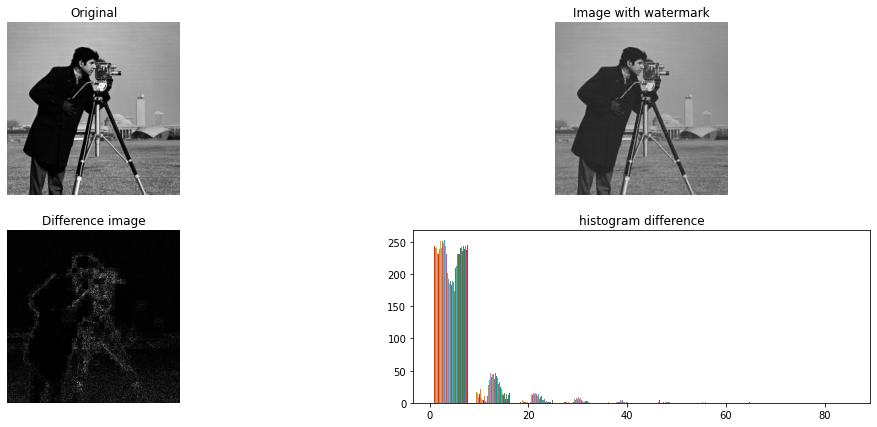


Testing sigma=0.500000 , alpha=0.250000 



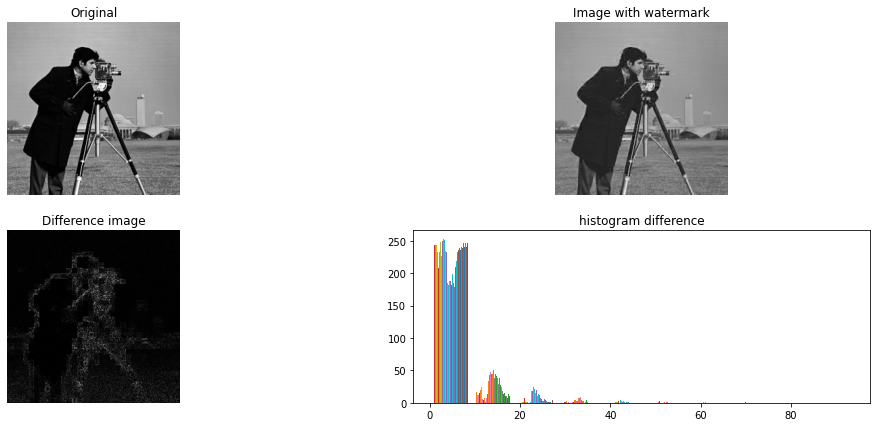


Testing sigma=0.010000 , alpha=0.500000 



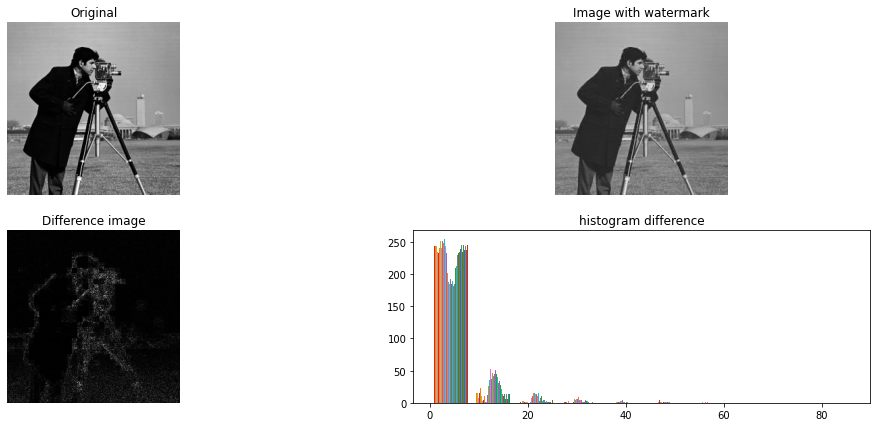


Testing sigma=0.100000 , alpha=0.500000 



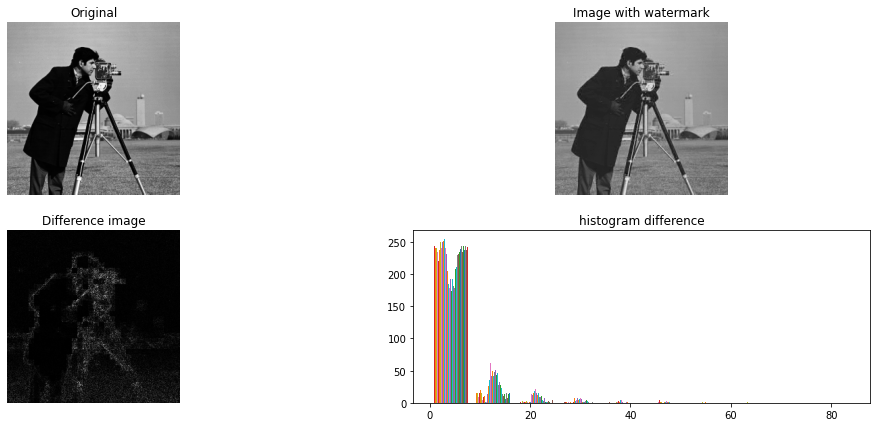


Testing sigma=0.500000 , alpha=0.500000 



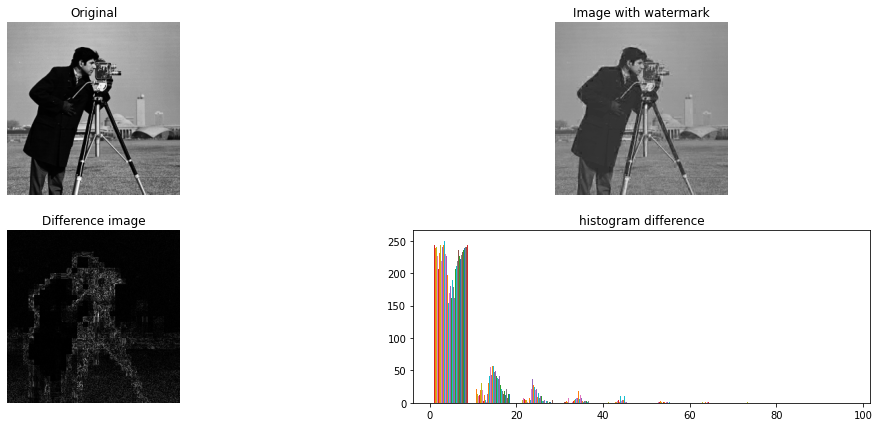

In [1150]:
#testing some alpha and sigma params
for alpha in [0.1, 0.25, 0.5]:
    for sigma in [0.01, 0.1, 0.5]:
        _,_,_ = insert_watermark(image, k_dct, sigma, alpha, debug=True)        # set test true

##### Steps
Embed the watermark,
Create the DCT of the watermarked image,
Compute the inverse DCT of the DCT with the new coefficients $ c^{'}_i $ ,
Display the original, the watermarked, their difference image
(explained where the code is)

In [1151]:
# keeping watermarked image with :
sigma = 0.05
alpha = 0.1
wk, marked, restored = insert_watermark(image, k_dct, sigma, alpha)     # gather marked image and w_k


##### Explain results




##### Explain why you do not put a watermark on the DC coefficients





## 2.2 Watermark Detection

Compute similarity of $\hat{\omega}_i$ with $\omega_i$ by $\\ \gamma = \frac{\sum^{K}_{i=1} (\hat{\omega}_i - \bar{\hat{\omega}}) \cdot (\omega_i - \bar{\omega})}{\sqrt{\sum^{K}_{i=1}(\hat{\omega}_i - \bar{\hat{\omega}})^2 \cdot \sum^{K}_{i=1} (\omega_i - \bar{\omega})^2}}, for\ 1 \leq i \leq K$

In [1152]:
def correlation_coefficient(wi, wi_hat):
    wi_mean = mean(wi); wi_hat_mean = mean(wi_hat)
    s1 = 0; s2 = 0; s3 = 0
    for i in r_[:sz[0]:8]:
        for j in r_[:sz[1]:8]:
            _wi = wi[i:i+8, j:j+8]; _wi_hat = wi_hat[i:i+8, j:j+8]
            # _wi = wi[i+1:i+8, j+1:j+8]; _wi_hat = wi_hat[i+1:i+8, j+1:j+8]

            _wk = _wi - wi_mean; _wk_hat = _wi_hat - wi_hat_mean
            s1 += sum(_wk * _wk_hat)
            s2 += sum(_wi_hat ** 2)
            s3 += sum(_wi ** 2)


    gamma = nan_to_num(s1 / sqrt(s2 * s3))
    print(gamma)
    watermark = gamma > 0.8                               # gamma > 0.8 , watermark is present
    return gamma, watermark




def estimate_watermark(m):
    show_images("mistery",[m],['image'],['gray'])
    all_dcts_hat = extract_dct(m)                      # compute 2-D DCT coefficients
    k_dcts_hat = k_largest_values(all_dcts_hat, 16)
    _wk_hat = zeros(wk.shape)
    # C_i, alpha, K are known from before

    for i in r_[:sz[0]:8]:
        for j in r_[:sz[1]:8]:
            block_hat = k_dcts_hat[i:i+8, j:j+8]
            block = k_dct[i:i+8, j:j+8]
            _wk_hat[i:i+8,j:j+8] = (block_hat - block) / (alpha * block)
            _wk_hat[i,j] = 0


    # measure the similarity of the coefficients

    gamma, watermark = correlation_coefficient(wk, _wk_hat) # compare similarity with threshold
    print("Correlation coefficient : %f" % gamma) # return whether watermark is present
    print("Does the image contain watermark ? %s" % watermark) # return whether watermark is present
    return watermark

You will be given a mistery image, and you will have to find if it is watermarked, comparing it with the known image.
Consider 2 Cases

#### Mistery image is the watermarked image

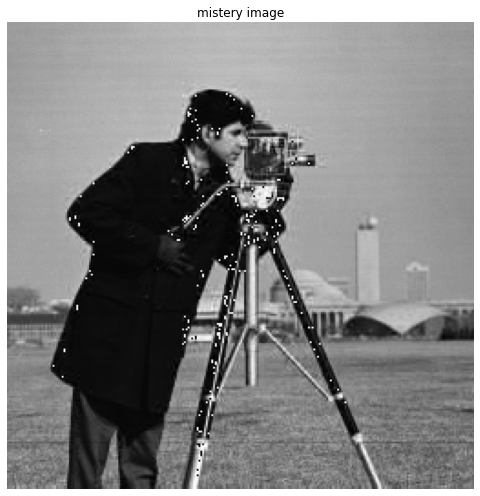

16384 non-zero coefficients 
0.0
Correlation coefficient : 0.000000
Does the image contain watermark ? False


C:\Users\Lorenzo\AppData\Local\Temp/ipykernel_11168/3490802233.py:34: RuntimeWarning: invalid value encountered in true_divide
  _wk_hat[i:i+8,j:j+8] = (block_hat - block) / (alpha * block)


In [1153]:
mistery1 = restored
marked1 = estimate_watermark(mistery1)

#### Mistery image is the original image

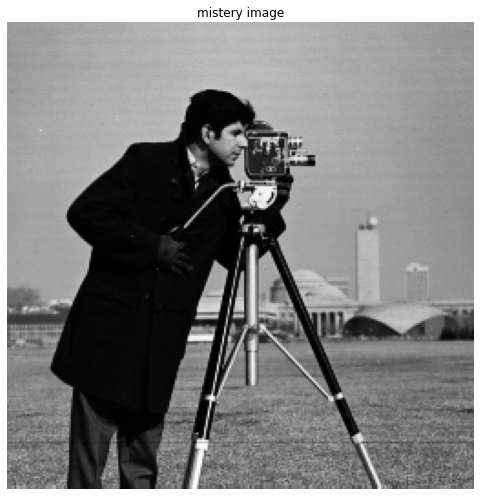

16384 non-zero coefficients 
0.0
Correlation coefficient : 0.000000
Does the image contain watermark ? False


C:\Users\Lorenzo\AppData\Local\Temp/ipykernel_11168/3490802233.py:34: RuntimeWarning: invalid value encountered in true_divide
  _wk_hat[i:i+8,j:j+8] = (block_hat - block) / (alpha * block)


In [1154]:
mistery2 = image
marked2 = estimate_watermark(image)

#### Show and explain results

In [1155]:
print(marked1, marked2)





False False
